# pytorch-image-models

* PyTorchの画像系のモデルや最適化手法などが実装されている
* torchvisionとtimmで実装
* [torchvison](https://github.com/pytorch/vision/tree/main/torchvision/models)
* [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm/models)

In [ ]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary
import timm
from sklearn.metrics import roc_auc_score
import warnings
import os
import time
import cv2
import copy

%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100) # 表示できる表の列数

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.__version__)

1.11.0+cu113


In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

# パラメータの設定

In [ ]:
# 学習率
lr = 0.01

# バッチサイズ
batch_size = 32

# エポック数
num_epochs = 50

# GPUに載せる
device = torch.device("cuda:0")

# モデルの構築
* torchvisonで実装されているモデルとtimmで実装されているモデルで出力のアーキテクチャが少し異なるので注意!

## torchvisionで実装できるモデル

In [ ]:
# torchvisionには例として以下のモデルが実装されており（他にもたくさんある）
# 全てのモデルに対してImageNet Pretrainを用いることが出来る
from torchvision import models

num_classes = 10

model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512,num_classes)
#alexnet = models.alexnet()
#vgg16 = models.vgg16()
#squeezenet = models.squeezenet1_0()
#densenet = models.densenet161()
#inception = models.inception_v3()
#googlenet = models.googlenet()
#shufflenet = models.shufflenet_v2_x1_0()
#mobilenet_v2 = models.mobilenet_v2()
#mobilenet_v3_large = models.mobilenet_v3_large()
#mobilenet_v3_small = models.mobilenet_v3_small()
#resnext50_32x4d = models.resnext50_32x4d()
#wide_resnet50_2 = models.wide_resnet50_2()
#mnasnet = models.mnasnet1_0()

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Pytorch image Modelsで実装されているモデル
* https://github.com/rwightman/pytorch-image-models/tree/master/timm/models

In [ ]:
#timm.list_models('resnet*',pretrained=True)
#timm.list_models('efficientnet*',pretrained=True)
#timm.list_models('vit_base*',pretrained=True)
#timm.list_models('reg*',pretrained=True)
timm.list_models('convnext*',pretrained=True)

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
#最終層の出力もnum_classesの入力で調整してくれるっぽい
class Model(nn.Module):
    def __init__(self, num_classes=10,  pretrained=True):
        super().__init__()
        self.net = timm.create_model('convnext_large', num_classes=num_classes,  pretrained=pretrained)
    
    def forward(self,x):
        x=self.net(x)
        return x

model = Model().to(device)

## モデルの表示

In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 56, 56]           9,408
       LayerNorm2d-2          [-1, 192, 56, 56]             384
          Identity-3          [-1, 192, 56, 56]               0
            Conv2d-4          [-1, 192, 56, 56]           9,600
         LayerNorm-5          [-1, 56, 56, 192]             384
            Linear-6          [-1, 56, 56, 768]         148,224
              GELU-7          [-1, 56, 56, 768]               0
           Dropout-8          [-1, 56, 56, 768]               0
            Linear-9          [-1, 56, 56, 192]         147,648
          Dropout-10          [-1, 56, 56, 192]               0
              Mlp-11          [-1, 56, 56, 192]               0
         Identity-12          [-1, 192, 56, 56]               0
    ConvNeXtBlock-13          [-1, 192, 56, 56]               0
           Conv2d-14          [-1, 192,

# 学習する関数の定義

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
  since = time.time()

  #保存するリスト
  loss_history = []
  acc_history = []
  auc_history = []
  val_loss_history = []
  val_acc_history = []
  val_auc_history = []

  #最も精度の良いモデルを保存するリスト
  best_model_weights = copy.deepcopy(model.state_dict())

  #Acuracy値の初期値
  best = 0.0

  #学習の繰り返し
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*60)

    for phase in ['train','val']:
      if phase == 'train':
        #モデルを学習用の状態へ
        model.train()
      else :
        #モデルを評価用の状態へ
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      #dataloaderによる学習および評価の繰り返し
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        

        #勾配の値のリセット
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          #ここは少し謎
          if is_inception and phase == 'train':
            #勾配消失問題を解決するための補助分類機の損失も計算
            outputs, aux_outputs == model(inputs)
            #損失の計算
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

          #予測値(分類値)の出力
          _, preds = torch.max(outputs, 1)

          #誤差の逆伝播とパラメータの更新を行う
          if phase == 'train':
            loss.backward()
            optimizer.step()

        #損失とAccuracyを集計
        #バッチサイズをかけるためにinputs.size(0)で出力している(最後のバッチは同じ大きさだとは限らないため)
        #trainとvalのlossを両方計算に入れて良いのか
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      #損失の計算
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      #Accuracyの計算
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))


      #Accuracyの保存
      if phase == 'train':
        acc_history.append(epoch_acc)
        loss_history.append(epoch_loss)

#      AUCの保存(二値分類の時用?)
#      labels = labels.cpu().data.numpy()
#      outputs = outputs.cpu().data.numpy()
#      epoch_auc = roc_auc_score(labels, outputs, multi_class='ovr') #マルチクラスの指定
#      auc_history.append(epoch_auc)

      
      #valのAccuracyの保存
      if phase == 'val':
        val_acc_history.append(epoch_acc)
        val_loss_history.append(epoch_loss)


#      valのAUCの保存(二値分類の時用?)
#      labels = labels.cpu().data.numpy()
#      outputs = outputs.cpu().data.numpy()
#      epoch_auc = roc_auc_score(labels, multi_class='ovr') #マルチクラスの指定
#      val_auc_history.append(epoch_auc)



      #モデルの保存
      if phase == 'val' and epoch_acc > best:    #AUCかAccuracyは好きな方に変更する
        best = epoch_acc
        best_model_weight = copy.deepcopy(model.state_dict())



  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Accuracy: {:4f}'.format(best))

  #最も精度の良いモデルを読み込む
  model.load_state_dict(best_model_weights)
  return model, loss_history, acc_history , auc_history, val_loss_history, val_acc_history, val_auc_history


# データの用意
* torchvisionで使えるtransformsのまとめ  
https://pystyle.info/pytorch-list-of-transforms/

In [ ]:
if not os.path.isfile('datasets/miniplaces/train/yard/00001000.jpg'):
    torchvision.datasets.utils.download_and_extract_archive(
        'https://dissect.csail.mit.edu/datasets/miniplaces.zip',
        'datasets', md5='bfabeb497c7eca01c74cd8441a9ac108')

  0%|          | 0/490696993 [00:00<?, ?it/s]

Extracting datasets/miniplaces.zip to datasets


In [ ]:
#オーグメンテーションの設定をする
#引数に入れた順番で処理されるらしい
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



#datasetの作成
#ImageFolderでは一つ目の引数に画像があるフォルダを指定する
#data = datasets.ImageFolder(root='datasets/miniplaces/train', transform = data_transforms['train'])

#train_ratio = 0.8
#trainとvalidationに分ける
#train_size = int(train_ratio * len(data))
# int()で整数に。
#val_size  = len(data) - train_size      
#data_size  = {"train":train_size, "val":val_size}

#data_train, data_val = torch.utils.data.random_split(data, [train_size, val_size])




# CIFAR10での学習

# CIFAR10の50000枚の訓練データを分割し、5000枚のみを用いる
train_dataset = datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=data_transforms['train'])
data_train, _ = torch.utils.data.random_split(train_dataset, [20000, 30000])

valid_dataset = datasets.CIFAR10('./data/cifar10', train=False, download=True, transform=data_transforms['val'])
data_val, _ = torch.utils.data.random_split(valid_dataset, [5000, 5000])





train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(data_val,   batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders_dict  = {"train":train_loader, "val":val_loader}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


# 学習の開始

In [ ]:
#optimizerの定義
#ここでは確率的勾配降下法
#momentumは学習速度(だんだん学習しにくくなる)
optimizer = optim.SGD(model.parameters(), lr = 0.001)

#損失関数の定義
criterion = nn.CrossEntropyLoss()

model, loss, acc, auc, val_loss, val_acc, val_auc = train_model(model, dataloaders_dict, 
                                                criterion, optimizer, num_epochs = num_epochs,
                                                is_inception=(model =="inception"))

Epoch 0/49
------------------------------------------------------------
train Loss: 2.1137 Accuracy: 0.3457
val Loss: 1.8931 Accuracy: 0.5450
Epoch 1/49
------------------------------------------------------------
train Loss: 1.6866 Accuracy: 0.6164
val Loss: 1.4956 Accuracy: 0.6616
Epoch 2/49
------------------------------------------------------------
train Loss: 1.3396 Accuracy: 0.6993
val Loss: 1.1992 Accuracy: 0.7200
Epoch 3/49
------------------------------------------------------------
train Loss: 1.0913 Accuracy: 0.7379
val Loss: 0.9996 Accuracy: 0.7428
Epoch 4/49
------------------------------------------------------------
train Loss: 0.9257 Accuracy: 0.7577
val Loss: 0.8630 Accuracy: 0.7608
Epoch 5/49
------------------------------------------------------------
train Loss: 0.8124 Accuracy: 0.7747
val Loss: 0.7744 Accuracy: 0.7758
Epoch 6/49
------------------------------------------------------------
train Loss: 0.7319 Accuracy: 0.7890
val Loss: 0.7100 Accuracy: 0.7880
Epoch 

# 学習したモデルを評価する

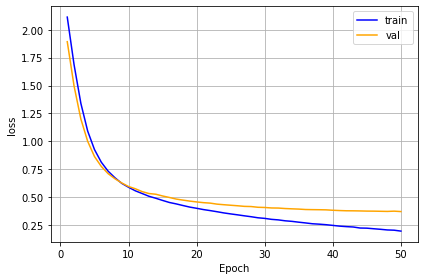

In [ ]:
#メモリをcudaからメインメモリに移す
loss = torch.tensor(loss, device = 'cpu')
val_loss = torch.tensor(val_loss, device = 'cpu')

fig, ax = plt.subplots()
t = np.arange(num_epochs) + 1
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
ax.grid()
ax.plot(t,loss, color = 'b',label='train')
ax.plot(t,val_loss, color = 'orange',label='val')
ax.legend(loc = 0)
fig.tight_layout()
plt.show()

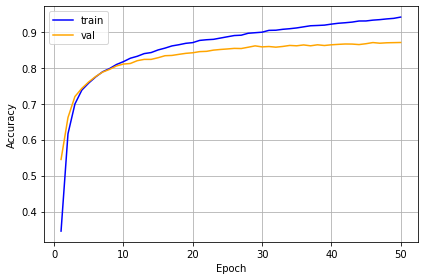

In [ ]:
#メモリをcudaからメインメモリに移す
acc = torch.tensor(acc, device = 'cpu')
val_acc = torch.tensor(val_acc, device = 'cpu')

fig, ax = plt.subplots()
t = np.arange(num_epochs) + 1
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid()
ax.plot(t, acc, color = 'b', label='train')
ax.plot(t, val_acc, color = 'orange', label='val')
ax.legend(loc = 0)
fig.tight_layout()
plt.show()

ValueError: ignored

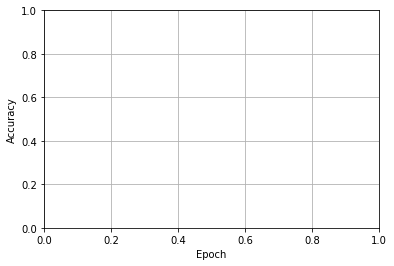

In [ ]:
#メモリをcudaからメインメモリに移す
auc = torch.tensor(auc, device = 'cpu')
val_auc = torch.tensor(val_auc, device = 'cpu')

fig, ax = plt.subplots()
t = np.arange(num_epochs) + 1
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid()
ax.plot(t, auc, color = 'b', label='train')
ax.plot(t, val_auc, color = 'orange', label='val')
ax.legend(loc = 0)
fig.tight_layout()
plt.show()